# Analysis of Sequential MC 

Below we will analyze the role of parameters on the performance of SMC with geometric path whose backward kernel is the reverse of forward kernel.

##### Parameters to evaluate:
- MC method: (2 for now) RWM and MALA
- step size: parameter in the MC step
- number of distributions on the path
- number of steps within each distribution

##### Standard of performance: 
- Variance of normalization factor Z

##### t = 0 Distribution
- Standard Gaussian with dim = 10

##### t = T Distribution
-  Student Distribution with dim = 10 and deg = 5


In [28]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np  

import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

from typing import TypedDict
import time
from scipy.special import logsumexp

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.smc.geometric_smc import GeometricSMC
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# initialize jax RNG
key = jr.key(0)

In [39]:
# Define intial and target distributions
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)

# deg = 5
# M = np.random.normal(0,1, (dim, dim))
# mu = np.random.normal(0,1, dim)
# cov = M @ M.T
# log_gamma_T = Student(mu=mu, cov=cov, deg=deg)

mu_1 = jnp.ones(dim)
sigma_1 = 2.
log_var_1 = jnp.log(sigma_1**2)
log_gamma_T = IsotropicGauss(mu=mu_1, log_var=log_var_1)


In [40]:
class Param(TypedDict):
    """ The class of one set of parameters """
    method: str  # MC method
    step_size: float    # step size in MC method
    num_dist: int      # number of distributions on the path
    num_step: int     # number of steps in each distribution 

### Method: RWM v.s. MALA

In [41]:
# Functions to calculate the normalizing constant estimator
def single_run(GSMC:GeometricSMC, num_particles, key, mc_method):
    t, _, log_weight_arr,*_ = GSMC.selfadaptive_run(num_particles, key, mc_method)
    return t, log_weight_arr

def mult_run(GSMC:GeometricSMC, num_particles, key, mc_method, num_run):
    keys = jr.split(key, num_run)
    batch_run = jax.vmap(single_run, in_axes=(None,None,0,None))
    batch_run = jax.jit(batch_run, static_argnums=(0,1,3))
    t_arr, log_weight_batch = batch_run(GSMC,num_particles,keys,mc_method)
    
    logZ_arr = [
        jnp.sum(logsumexp(log_weight_batch[i, :, 1:t] - jnp.log(num_particles), axis=0))
        for i, t in enumerate(t_arr)
    ]

    return jnp.array(logZ_arr)

def compute_variance(GSMC:GeometricSMC, key, num_particles, method,num_run):
    t_start = time.time()
    logZ_arr = mult_run(GSMC, num_particles, key, method, num_run)
    t_end = time.time() 
    print(f"Computation time (with jit): {t_end-t_start}")

    # Compute the variance of log(Z)
    variance = jnp.var(logZ_arr)
    mean = jnp.mean(logZ_arr)
    return mean, variance


In [42]:
'''
Compare the mean of log Z for two method: RWM and MALA, with fixed step_size and num_step, with num_dist 
varying from 10 to 100
'''
params = [Param(method='RWM', step_size=1, num_dist=num, num_step=5) for num in range(10,21,10)] 
num_particles = 1000
logZ_var_RWM = []
logZ_mean_RWM = []

num_run = 100

for i,param in enumerate(params):
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    logZ_mean, logZ_var = compute_variance(GSMC, key_, num_particles,method,num_run)
    logZ_var_RWM.append(logZ_var)
    logZ_mean_RWM.append(logZ_mean)
    print("-----------------------------------------------------")


params = [Param(method='MALA', step_size=1, num_dist=num, num_step=5) for num in range(10,21,10)]
logZ_var_MALA = []
logZ_mean_MALA = []
for param in params:
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    logZ_mean,logZ_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    logZ_mean_MALA.append(logZ_mean)
    logZ_var_MALA.append(logZ_var)
    print("-----------------------------------------------------")



Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 10, 'num_step': 5}
Computation time (with jit): 10.81265115737915
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 20, 'num_step': 5}
Computation time (with jit): 9.54921579360962
-----------------------------------------------------
Running with param:  {'method': 'MALA', 'step_size': 1, 'num_dist': 10, 'num_step': 5}
Computation time (with jit): 10.64514970779419
-----------------------------------------------------
Running with param:  {'method': 'MALA', 'step_size': 1, 'num_dist': 20, 'num_step': 5}
Computation time (with jit): 9.36276364326477
-----------------------------------------------------


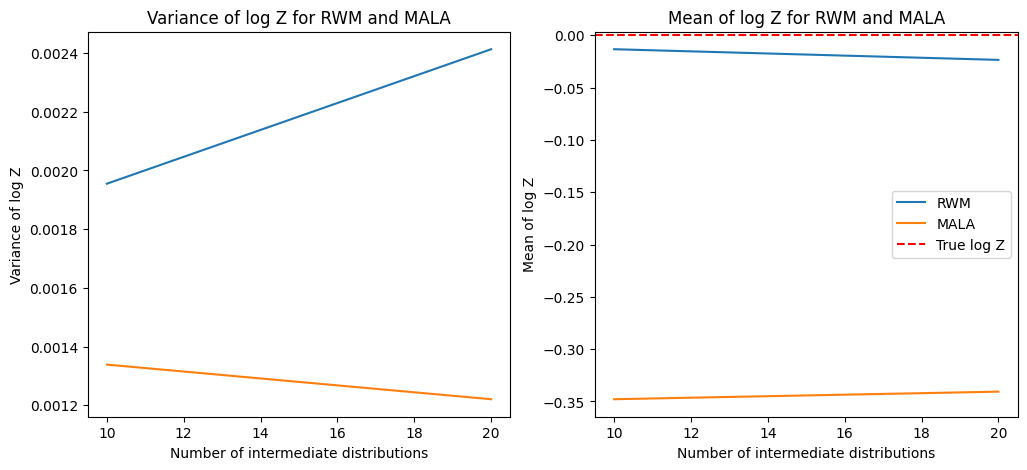

In [44]:
# Draw the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(range(10,21,10), logZ_var_RWM, label='RWM')    
axes[0].plot(range(10,21,10), logZ_var_MALA, label='MALA')
axes[0].set_xlabel('Number of intermediate distributions')
axes[0].set_ylabel('Variance of log Z')
axes[0].set_title('Variance of log Z for RWM and MALA')


axes[1].plot(range(10,21,10), jnp.array(logZ_mean_RWM) , label='RWM')
axes[1].plot(range(10,21,10), jnp.array(logZ_mean_MALA), label='MALA')
axes[1].axhline(y=0, color='r', linestyle='--', label='True log Z')
axes[1].set_xlabel('Number of intermediate distributions')
axes[1].set_ylabel('Mean of log Z')
axes[1].set_title('Mean of log Z for RWM and MALA')

plt.legend()


### Number of steps within each distribution

In [ ]:
'''
Compare the variance of Z for different number of steps: 1,2,5,10, with fixed step_size and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='MALA', step_size=1, num_dist=num, num_step=step) for num in range(10, 101, 10) for step in [1,2,5,10]]
Z_var_MALA = []
num_particles = 1000
num_run = 100

for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    Z_var_MALA.append(Z_var)



Computation time (with jit): 7.346532344818115
Computation time (with jit): 8.548167705535889
Computation time (with jit): 8.638608694076538
Computation time (with jit): 10.297006845474243
Computation time (with jit): 6.669503927230835
Computation time (with jit): 7.142929792404175
Computation time (with jit): 11.007278442382812
Computation time (with jit): 23.643920421600342
Computation time (with jit): 14.202423334121704
Computation time (with jit): 14.618042945861816
Computation time (with jit): 10.270800590515137
Computation time (with jit): 16.20397448539734
Computation time (with jit): 7.399408578872681
Computation time (with jit): 8.692729711532593
Computation time (with jit): 25.09266424179077
Computation time (with jit): 46.4853937625885
Computation time (with jit): 25.22499656677246
Computation time (with jit): 28.287908792495728
Computation time (with jit): 44.03798747062683
Computation time (with jit): 64.90661716461182
Computation time (with jit): 29.35231113433838
Computa

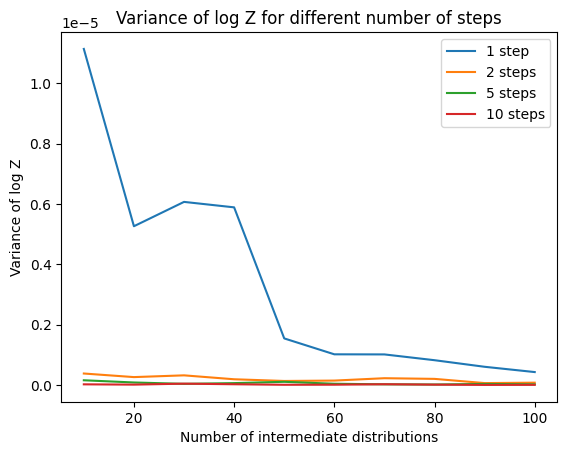

In [11]:
# plot the variance of Z for different number of steps
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:10], label='1 step')
plt.plot(range(10, 101, 10), Z_var_MALA[10:20], label='2 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[20:30], label='5 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[30:], label='10 steps')
plt.xlabel('Number of intermediate distributions')
plt.ylabel('Variance of log Z')
plt.title('Variance of log Z for different number of steps')
plt.legend()

### Step size within each distribution

In [12]:
'''
Compare the variance of Z for different number of step_size: 0.1,0.5,1.0,5.0, with fixed num_step = 5 and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='RWM', step_size=step, num_dist=num, num_step=5) for num in range(10, 101, 10) for step in [0.1,0.5,1.0,5.0]]
Z_var_MALA = []
num_particles = 1000
num_run = 100

for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    Z_var_MALA.append(Z_var)




Computation time (with jit): 18.21195912361145
Computation time (with jit): 19.09274697303772
Computation time (with jit): 12.570969104766846
Computation time (with jit): 7.783427715301514
Computation time (with jit): 10.519567966461182
Computation time (with jit): 12.370636701583862
Computation time (with jit): 10.544171571731567
Computation time (with jit): 19.82406520843506
Computation time (with jit): 28.374971389770508
Computation time (with jit): 27.980350255966187
Computation time (with jit): 11.725957155227661
Computation time (with jit): 13.650598526000977
Computation time (with jit): 17.806469678878784
Computation time (with jit): 32.468238830566406
Computation time (with jit): 24.966492652893066
Computation time (with jit): 18.651287078857422
Computation time (with jit): 18.915075063705444
Computation time (with jit): 34.83015489578247
Computation time (with jit): 28.69912886619568
Computation time (with jit): 27.986029624938965
Computation time (with jit): 26.24924874305725

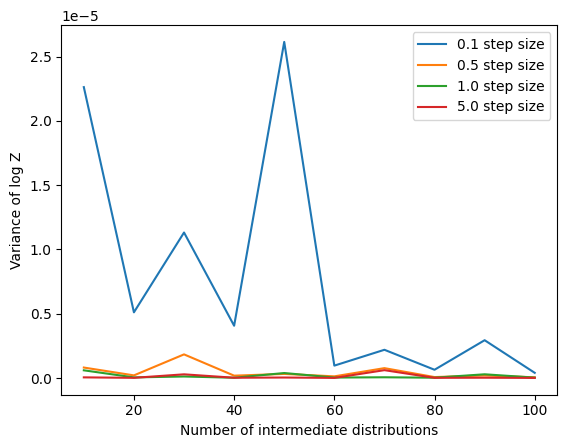

In [13]:
# plot
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:10], label='0.1 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[10:20], label='0.5 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[20:30], label='1.0 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[30:], label='5.0 step size')
plt.xlabel('Number of intermediate distributions')
plt.ylabel('Variance of log Z')
plt.legend()



### Boxplot of Log Z (Normalization Factor) with respect to N

In [ ]:
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)


mu_1 = jnp.ones(dim)
sigma_1 = 0.3
log_var_1 = jnp.log(sigma_1**2)
log_gamma_T = IsotropicGauss(mu=mu_1, log_var=log_var_1)


num_particles_arr = [50, 100, 500, 1000, 2000]
num_run = 500
N = 10
coefs = jnp.arange(N+1)/N
method = "MALA"
data1 = {"N_arr": num_particles_arr, "logZ": []}
for num_particles in num_particles_arr:
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                    step_size=1, num_substeps=10)
    print("Running with num_particles: ", num_particles)
    key, key_ = jr.split(key)
    logZ_arr = mult_run(GSMC, num_particles=num_particles, key=key_, mc_method=method, num_run = num_run)
    data1["logZ"].append(logZ_arr)


Running with num_particles:  50
Running with num_particles:  100
Running with num_particles:  500
Running with num_particles:  1000
Running with num_particles:  2000


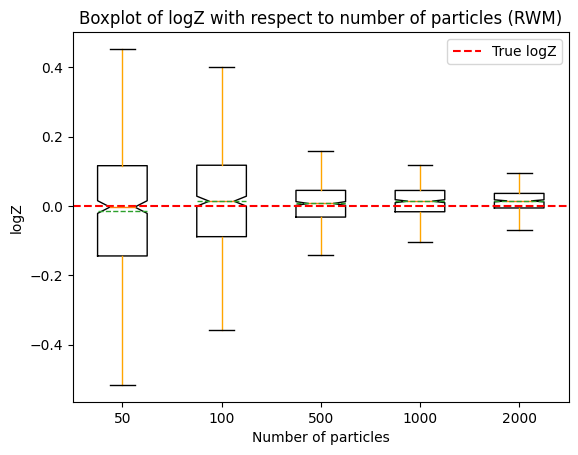

In [ ]:
# plot boxplot of logZ with confidence interval and mean
plt.figure()
positions = np.arange(len(num_particles_arr))
plt.boxplot(data1["logZ"], positions=positions, showmeans=True, meanline=True, notch=True, showfliers=False, whiskerprops=dict(color='orange'))

# compare to logZ of funnel distribution
plt.axhline(y=0, color='r', linestyle='--', label='True logZ')

plt.xticks(positions, num_particles_arr)
plt.xlabel('Number of particles')
plt.ylabel('logZ')
plt.title(f'Boxplot of logZ with respect to number of particles ({method})')
plt.legend()
plt.show()